In [25]:
# === Add "Move Separation" and "Release Burst" to cb_wr_data ===
# Requirements: pandas, numpy
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [5]:
cb_wr_data = pd.read_csv("custom/CB_WR_data.csv")  # Load your existing dataframe

In [38]:
# ----------------- CONFIG -----------------
GAMES_CSV = "data/games.csv"
WEEK_GLOB = "data/week*.csv"

# Move detection (dir-based) params
ANGLE_DEG_THRESH   = 7.5   # degrees change considered a "move"
MIN_SPEED_YDPS     = 1.5    # require min speed at move; set 0.0 to ignore
DIR_SMOOTH_WINDOW  = 5      # circular smoothing window (frames)
FRAMES_AFTER_SNAP  = 3      # start checking at ball_snap + N

# Separation sampling offsets from move frame (single frames)
SEP_BEFORE_OFFSET  = -3
SEP_AFTER_OFFSET   = +3

# Release burst window after snap (at ~10Hz)
EARLY_FRAMES = 10          # snap+1 .. snap+10
SMOOTH_K     = 3           # small moving average for speed

# ----------------- HELPERS -----------------
def _load_games():
    if not os.path.exists(GAMES_CSV):
        raise FileNotFoundError(f"Missing {GAMES_CSV}")
    return pd.read_csv(GAMES_CSV)[["gameId","week"]]

_GAMES = _load_games()
_WEEK_CACHE = {}

def _load_week_for_game(game_id: int) -> pd.DataFrame:
    """Load the tracking week DataFrame that contains this game."""
    row = _GAMES.loc[_GAMES["gameId"] == game_id]
    if row.empty:
        raise ValueError(f"gameId {game_id} not in games.csv")
    wk = int(row.iloc[0]["week"])
    if wk in _WEEK_CACHE:
        return _WEEK_CACHE[wk]
    # Prefer canonical path
    path = f"data/week{wk}.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        _WEEK_CACHE[wk] = df
        return df
    # Fallback: search week*.csv
    for wf in sorted(glob.glob(WEEK_GLOB)):
        try:
            tmp = pd.read_csv(wf, usecols=["gameId"])
            if (pd.to_numeric(tmp["gameId"], errors="coerce") == game_id).any():
                df = pd.read_csv(wf)
                _WEEK_CACHE[wk] = df
                return df
        except Exception:
            continue
    raise FileNotFoundError(f"Week file for game {game_id} not found.")

def _circ_smooth(theta_rad: np.ndarray, k: int) -> np.ndarray:
    if k <= 1 or len(theta_rad) < k:
        return theta_rad
    box = np.ones(k)/k
    sin_sm = np.convolve(np.sin(theta_rad), box, mode="same")
    cos_sm = np.convolve(np.cos(theta_rad), box, mode="same")
    return np.arctan2(sin_sm, cos_sm)

def find_first_move_frame(track_df, by, val, angle_deg_thresh=2.0, min_speed=0.0):
    """
    Find the first frame where the highlighted WR changes heading by >= angle_deg_thresh
    while moving at >= min_speed. Returns (frameId, x, y) or (None, None, None).
    Heading from successive positions; angle diff is unwrapped for robustness.
    """

    # Restrict tracking data to frames after the ball snap (plus 3)
    snap_rows = track_df.loc[track_df["event"].astype(str).str.lower() == "ball_snap"]
    snap_frame = int(pd.to_numeric(snap_rows["frameId"], errors="coerce").min())
    track_df = track_df[pd.to_numeric(track_df["frameId"], errors="coerce") >= (snap_frame + 3)].copy()
    #print(f"Tracking data filtered: kept {len(track_df)} rows after ball_snap (starting at frame {snap_frame + 3})")

    # Restrict tracking data to frames before the pass_forward
    before_pass_rows = track_df.loc[track_df["event"].astype(str).str.lower() == "pass_forward"]
    if before_pass_rows.empty:
        return (None, None, None)
    before_pass_frame = int(pd.to_numeric(before_pass_rows["frameId"], errors="coerce").min())
    track_df = track_df[pd.to_numeric(track_df["frameId"], errors="coerce") < before_pass_frame].copy()
    #print(f"Tracking data filtered: kept {len(track_df)} rows before pass_forward (up to frame {before_pass_frame + 3})")

    wr = track_df[track_df[by] == val].dropna(subset=["frameId", "x", "y"]).copy()
    wr = wr.sort_values("frameId")
    #print(len(track_df), "asdfdsfsfdsf")

    dir_eff = wr["dir"].values
    spd_eff = wr["s"].values

    n = len(dir_eff)

    frames = wr["frameId"].values
    
    xs = wr["x"].values
    ys = wr["y"].values

    #print(dir_eff)
    #print(spd_eff)

    idx = None
    for i in range(1,n):
        if (np.abs(dir_eff[i] - dir_eff[i-1]) >= angle_deg_thresh) and (spd_eff[i] >= min_speed):
            idx = i   
            break

    if idx is None:
        return (None, None, None)

    return (int(frames[idx]), float(xs[idx]), float(ys[idx]))

def _separation_at_frame(track_play_df: pd.DataFrame, off_id: int, def_id: int, frame_id: int):
    """Return WR–CB separation (yards) at a specific frame, or np.nan."""
    if frame_id is None or not np.isfinite(frame_id):
        return np.nan
    f = int(frame_id)
    wr = track_play_df[(track_play_df["nflId"] == off_id) & (pd.to_numeric(track_play_df["frameId"], errors="coerce") == f)]
    cb = track_play_df[(track_play_df["nflId"] == def_id) & (pd.to_numeric(track_play_df["frameId"], errors="coerce") == f)]
    if wr.empty or cb.empty:
        return np.nan
    try:
        dx = float(wr["x"].iloc[0]) - float(cb["x"].iloc[0])
        dy = float(wr["y"].iloc[0]) - float(cb["y"].iloc[0])
        return float(np.hypot(dx, dy))
    except Exception:
        return np.nan

def _ma(x, k=3):
    if k <= 1 or len(x) < k:
        return x
    box = np.ones(k)/k
    return np.convolve(x, box, mode="same")

def _release_burst_for_wr(track_play_df: pd.DataFrame, wr_id: int) -> float:
    """max(speed in snap+1..snap+EARLY_FRAMES) - speed at snap+1; 0 if unavailable."""
    if "event" not in track_play_df.columns:
        return 0.0
    tdf = track_play_df.copy()
    for c in ["frameId","nflId","s"]:
        if c in tdf.columns:
            tdf[c] = pd.to_numeric(tdf[c], errors="coerce")
    tdf["event"] = tdf["event"].astype(str).str.lower()

    snap = tdf.loc[tdf["event"] == "ball_snap", "frameId"]
    if snap.empty:
        return 0.0
    snap_frame = int(snap.min())

    wr = tdf.loc[tdf["nflId"] == wr_id, ["frameId","s"]].dropna(subset=["frameId"]).copy()
    if wr.empty:
        return 0.0
    wr = wr.sort_values("frameId")
    win = wr[(wr["frameId"] >= snap_frame + 1) & (wr["frameId"] <= snap_frame + EARLY_FRAMES)]
    if win.empty:
        return 0.0

    spd = pd.to_numeric(win["s"], errors="coerce").fillna(0.0).to_numpy()
    spd = _ma(spd, SMOOTH_K)
    base = spd[0]
    peak = float(np.max(spd))
    burst = peak - base
    if not np.isfinite(burst):
        return 0.0
    return float(max(burst, 0.0))

# ----------------- MAIN: ADD FEATURES -----------------
def add_move_and_burst_features(cb_wr_data: pd.DataFrame,
                                game_col="gameId", play_col="playId",
                                off_col="nflIdOff", def_col="nflIdDef") -> pd.DataFrame:
    """
    Adds two columns to cb_wr_data and returns it:
      - "Move Separation": (sep at move+3) - (sep at move-3); 0 if no move or unavailable
      - "Release Burst": WR early acceleration metric after snap; 0 if unavailable
    """
    out = cb_wr_data.copy()
    out["Move Separation"] = 0.0
    out["Release Burst"]   = 0.0

    # Process by play to avoid re-reading week files repeatedly
    for (g, p), idx in out.groupby([game_col, play_col], sort=False).groups.items():
        try:
            g_int = int(g); p_int = int(p)
        except Exception:
            continue

        # Load the tracking for this play
        try:
            wkdf = _load_week_for_game(g_int)
        except Exception:
            continue

        tp = wkdf[(pd.to_numeric(wkdf["gameId"], errors="coerce") == g_int) &
                  (pd.to_numeric(wkdf["playId"], errors="coerce") == p_int)].copy()
        if tp.empty:
            continue

        # Ensure needed columns numeric
        for c in ["frameId","nflId","x","y","dir","s"]:
            if c in tp.columns:
                tp[c] = pd.to_numeric(tp[c], errors="coerce")
        if "event" in tp.columns:
            tp["event"] = tp["event"].astype(str)

        # Compute burst once per (game,play) for each specific WR row
        for row_i in (idx if isinstance(idx, (list, np.ndarray, pd.Index)) else [idx]):
            try:
                wr_id = int(out.at[row_i, off_col])
                cb_id = int(out.at[row_i, def_col])
            except Exception:
                continue

            # Release Burst
            burst = _release_burst_for_wr(tp, wr_id=wr_id)
            out.at[row_i, "Release Burst"] = float(burst)

            # Move Separation
            HIGHLIGHT_WR_BY = "nflId"
            HIGHLIGHT_WR_VAL = wr_id
            mf, mx, my  = find_first_move_frame(
                tp, HIGHLIGHT_WR_BY, wr_id, angle_deg_thresh=ANGLE_DEG_THRESH,
                min_speed=MIN_SPEED_YDPS
            )
            if mf is None or not np.isfinite(mf):
                out.at[row_i, "Move Separation"] = 0.0
                continue

            sep_before = _separation_at_frame(tp, wr_id, cb_id, int(mf + SEP_BEFORE_OFFSET))
            sep_after  = _separation_at_frame(tp, wr_id, cb_id, int(mf + SEP_AFTER_OFFSET))

            sep_created = 0.0
            if np.isfinite(sep_before) and np.isfinite(sep_after):
                sep_created = float(sep_after - sep_before)
            out.at[row_i, "Move Separation"] = sep_created

    return out

# ----------------- RUN ON YOUR DATAFRAME -----------------
# Assumes cb_wr_data already exists in memory with columns:
# ['gameId','playId','nflIdOff','nflIdDef', ...]

# Inspect:
# cb_wr_data[["gameId","playId","nflIdOff","nflIdDef","Move Separation","Release Burst"]].head()


In [39]:
cb_wr_data = add_move_and_burst_features(cb_wr_data)

In [47]:
cb_wr_data

,Unnamed: 0,gameId,playId,successOff,manCoverage,targetOff,nflIdDef,defPlayerName,defenseTeam,defPos,...,heightAdv,route,WR,TE,RB,CB,FS,WRToCBRatio,Move Separation,Release Burst
0,1,2018090600,75,True,False,True,2555383,Jalen Mills,PHI,CB,...,-3.0,HITCH,2,1,1,2,2,1.000000,0.760938,4.283333
1,2,2018090600,146,False,False,False,2552689,Ronald Darby,PHI,CB,...,1.0,HITCH,3,1,1,3,1,1.000000,0.000000,3.630000
2,3,2018090600,146,False,False,False,2557958,Sidney Jones,PHI,CB,...,2.0,CROSS,3,1,1,3,1,1.000000,0.000000,3.223333
3,4,2018090600,146,False,False,True,2555383,Jalen Mills,PHI,CB,...,-1.0,HITCH,3,1,1,3,1,1.000000,0.000000,2.750000
4,5,2018090600,168,False,False,False,2552689,Ronald Darby,PHI,CB,...,-3.0,SLANT,2,1,2,3,1,0.666667,0.000000,3.146667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2404,2018091001,4147,True,False,False,1302,Aqib Talib,LA,CB,...,0.0,GO,3,1,1,3,1,1.000000,0.000000,4.423333
2404,2405,2018091001,4147,True,False,False,2540197,Nickell Robey-Coleman,LA,CB,...,-6.0,FLAT,3,1,1,3,1,1.000000,0.000000,3.790000
2405,2406,2018091001,4147,True,False,False,2552488,Marcus Peters,LA,CB,...,NaN,GO,3,1,1,3,1,1.000000,0.000000,3.906667
2406,2407,2018091001,4192,False,False,False,2540197,Nickell Robey-Coleman,LA,CB,...,-5.0,IN,3,1,1,3,1,1.000000,0.000000,3.460000


In [46]:
#save this to csv new
cb_wr_data.to_csv("custom/CB_WR_data_with_burst_and_move_sep_new.csv", index=False)

In [52]:
targeted_df = cb_wr_data[cb_wr_data["targetOff"] == True].copy()
non_zero_sep = targeted_df[targeted_df["Move Separation"] != 0.0]

In [53]:
len(non_zero_sep)

146

In [54]:
sep_created = non_zero_sep["Move Separation"]
success_numeric = non_zero_sep["successOff"].astype(int)

In [55]:
sep_created

0       0.760938
10     -0.535315
14      0.117511
23     -0.448384
35     -1.230672
          ...   
2223   -0.729398
2231   -0.379369
2286   -2.155839
2318   -1.511086
2380    0.460992
Name: Move Separation, Length: 146, dtype: float64

Text(0.5, 1.0, 'Separation Created vs Play Success for Targeted WRs')

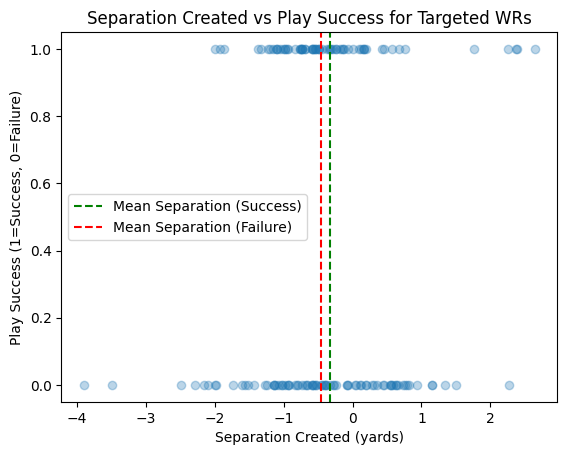

In [56]:
plt.scatter(sep_created, success_numeric, alpha=0.3)
plt.xlabel("Separation Created (yards)")
plt.ylabel("Play Success (1=Success, 0=Failure)")

# show the mean for both successes and failures
mean_sep_success = sep_created[success_numeric == 1].mean()
mean_sep_failure = sep_created[success_numeric == 0].mean()
plt.axvline(mean_sep_success, color='g', linestyle='--', label='Mean Separation (Success)')
plt.axvline(mean_sep_failure, color='r', linestyle='--', label='Mean Separation (Failure)')
plt.legend()
plt.title("Separation Created vs Play Success for Targeted WRs")

In [59]:
release_burst = targeted_df["Release Burst"]
succ_2 = targeted_df["successOff"].astype(int)

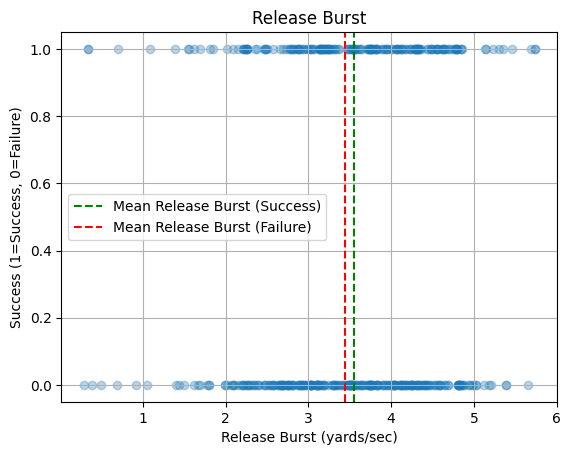

: 

In [ ]:
plt.scatter(release_burst, succ_2, alpha=0.3)
plt.xlabel("Release Burst (yards/sec)")
plt.ylabel("Success (1=Success, 0=Failure)")
plt.title("Release Burst")
# means
mean_burst_success = release_burst[succ_2 == 1].mean()
mean_burst_failure = release_burst[succ_2 == 0].mean()
plt.axvline(mean_burst_success, color='g', linestyle='--', label='Mean Release Burst (Success)')
plt.axvline(mean_burst_failure, color='r', linestyle='--', label='Mean Release Burst (Failure)')
plt.legend()
plt.grid(True)

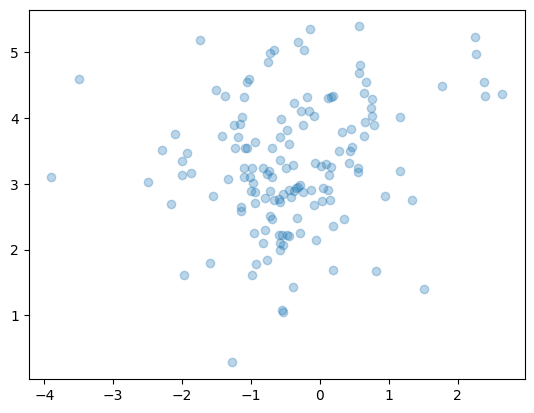

In [62]:
plt.plot(sep_created, non_zero_sep['Release Burst'], 'o', alpha=0.3)